## Importing Libraries

In [ ]:
import re
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The given CSV file is read by setting 'keep_default_na' argument to False.
# Reason: To check for the presence of different garbage values, 
# (like 'NA', '?', '-') and handle them separately

base_dir = '/content/drive/MyDrive/Learnings/Case_Studies/Lending_Club/'
infile = 'loan.csv'
df = pd.read_csv(base_dir+infile, keep_default_na=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (49,78,105,106) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Defined Functions for Analysis

In [ ]:
def get_categories_info(data_frame):
  """
  Identifies the categories and their count, in all categorical columns of a dataframe.
  """
  catg_df = pd.DataFrame()
  for col in data_frame.select_dtypes(include=['O']):
    row = pd.DataFrame({'col_name':[col], 'n_categories':[data_frame[col].nunique()], 'categories':[str(data_frame[col].unique())]})
    catg_df = pd.concat([catg_df, row], ignore_index=True)
  
  return catg_df

In [ ]:
def get_garbage_info(data_frame):
  """
  Checks if a column contains any garbage values and
  displays the count and their percentage.
  """
  garbage_values = ['', ' ', '?', '-', 'NA', 'na', 
                    'N/A', 'n/a', 'NONE', 'None', 
                    'none', 'NULL','null', 'NAN',
                    'nan']

  gb_df = pd.DataFrame()

  catg_cols = data_frame.select_dtypes(include=['O']).columns
  nrows = data_frame.shape[0]
  for col in catg_cols:
    freq_cnts = data_frame[col].value_counts()
    temp_df = freq_cnts[freq_cnts.index.isin(garbage_values)].to_frame().reset_index().rename(columns={'index':'garbage_value', col:'count'})
    
    if len(temp_df) > 0:
      temp_df['column'] = col
      temp_df['perct'] = round((temp_df['count']/nrows)*100, 2)
      gb_df = pd.concat([gb_df, temp_df], ignore_index=True)

  return gb_df[['column', 'garbage_value', 'count', 'perct']]
  

In [ ]:
def plot_loan_proportions_across(data_frame, across_col1, 
                                 across_col2='loan_status', 
                                 plot_type='bar', title=None,
                                 rotate=False):
  """
  Generates a bar plot or stacked bar plot based on 
  proportion of fully paid and charged off loans across
  a given category column 
  """
  temp_df = data_frame.groupby(across_col2)[across_col1].value_counts(normalize=True, sort=False)
  temp_df.name = None
  temp_df = temp_df.reset_index()
  temp_df.columns = [across_col2, across_col1, 'percent']
  fig, ax = plt.subplots(figsize=(8, 6))
  if plot_type == 'bar':
    sns.barplot(data=temp_df, x=across_col1, y='percent', hue=across_col2, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Proportion of Loans')
    if rotate:
      ax.set_xticklabels(labels=temp_df[across_col1].unique(), rotation=90)
    plt.show()
  elif plot_type =='stacked_bar':
    temp_df = temp_df.pivot_table(columns=[across_col1], index=across_col2)
    temp_df.columns = temp_df.columns.droplevel(0)
    temp_df.plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Proportion of Loans')
    ax.legend(bbox_to_anchor=(1.01, 0.35))
    plt.show()

In [ ]:
def plot_numerical_distribution(data_frame, col):
  """
  Generates histogram and boxplot of a numerical column
  """
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))
  ax1, ax2 = axes
  sns.histplot(data=data_frame, x=col, ax=ax1)
  ax1.set_title(f'Histogram of column: {col}')
  ax1.set_xlabel(None)
  sns.boxplot(data=data_frame, y=col)
  ax2.set_title(f'Boxplot of column: {col}')
  plt.show()

## Data Understanding

In [ ]:
# Determining the number of loan applications and 
# the number of attributes assocaited with each application
nrows, ncols = df.shape
print(f'Number of loans: {nrows}')
print(f'Number of attributes considered for each application: {ncols}')

Number of loans: 39717
Number of attributes considered for each application: 111


In [ ]:
# Viewing the different column data types
# and the number of columns with each data type
df.dtypes.value_counts()

object     84
float64    14
int64      13
dtype: int64

In [ ]:
# Determing the number of numeric and categorical cols
ncatg_cols = len(df.select_dtypes(include=["O"]).columns)
nnum_cols = len(df.select_dtypes(include=["number"]).columns)
print(f'Number of numerical attributes: {nnum_cols}')
print(f'Number of catgeorical attributes: {ncatg_cols}')

Number of numerical attributes: 27
Number of catgeorical attributes: 84


In [ ]:
# Viewing top 5 rows
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NA,NA,NA,NA,0,0,NA,NA,NA,NA
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NA,NA,NA,NA,0,0,NA,NA,NA,NA
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NA,NA,NA,NA,0,0,NA,NA,NA,NA
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NA,NA,NA,NA,0,0,NA,NA,NA,NA
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NA,NA,NA,NA,0,0,NA,NA,NA,NA


### Identifying Target column

- **Target column**: The column containing information if a loan is a defualted one or not.
- Based on column definitions in data dictionary, **loan_status** can provide similar information.

In [ ]:
# Viewing the categories of 'loan_status' column
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current'], dtype=object)

#### Observations
- Data provided for the three types of loans: `Fully Paid`, `Charged Off` and `Current`
- `Fully Paid` loans are informative for understanding factors for not defaulting. 
- `Charged Off` loans are informative for understanding factors for defaulting.
- On the other hand, `Current` loans as no info if a loan has defaulted or not. Hence these loans can be dropped.

### Identify columns with garbage columns

In [ ]:
# Obtaining count of each garbage value identifed across all columns
garbage_count = get_garbage_info(df)

In [ ]:
garbage_count.head()

,column,garbage_value,count,perct
0,emp_title,,2453,6.18
1,emp_title,N/A,5,0.01
2,emp_title,n/a,1,0.00
3,emp_length,n/a,1075,2.71
4,home_ownership,NONE,3,0.01


In [ ]:
# aggregating by column
garbage_cols = garbage_count.groupby('column')[['count', 'perct']].sum().sort_values('perct', ascending=False)

In [ ]:
# Viewing columns with more than 30% of garbage values
garbage_cols.loc[garbage_cols.perct > 30.0]

,count,perct
column,,
acc_open_past_24mths,39717,100.00
num_accts_ever_120_pd,39717,100.00
num_actv_rev_tl,39717,100.00
num_bc_sats,39717,100.00
num_bc_tl,39717,100.00
num_il_tl,39717,100.00
num_op_rev_tl,39717,100.00
num_rev_accts,39717,100.00
num_rev_tl_bal_gt_0,39717,100.00


In [ ]:
high_garbage_cols = garbage_cols.loc[garbage_cols.perct > 30.0].index
print(f'Number of columns with high percentage of garbage values: {len(high_garbage_cols)}')
print('Columns with high percentage of garbage values are: ')
print(high_garbage_cols)

Number of columns with high percentage of garbage values: 58
Columns with high percentage of garbage values are: 
Index(['acc_open_past_24mths', 'num_accts_ever_120_pd', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m',
       'open_rv_12m', 'open_rv_24m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort',
       'total_bal_il', 'total_bc_limit', 'total_cu_tl',
       'total_il_high_credit_limit', 'total_rev_hi_lim', 'all_util',
       'num_actv_bc_tl', 'inq_fi', 'mo_sin_old_rev_tl_op', 'annual_inc_joint',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'dti_joint', 'il_util',
       'mths_since_recent_revol_delinq', 'inq_last_12m', 'max_bal_bc',
       'mo_sin_old_il_acct', 'v

In [ ]:
low_garbage_cols = garbage_cols.loc[garbage_cols.perct <= 30.0].index
print(low_garbage_cols)

Index(['emp_title', 'emp_length', 'pub_rec_bankruptcies', 'last_pymnt_d',
       'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'revol_util',
       'tax_liens', 'title', 'home_ownership', 'last_credit_pull_d'],
      dtype='object', name='column')


In [ ]:
low_garbage_count=get_garbage_info(df[low_garbage_cols])
low_garbage_count

,column,garbage_value,count,perct
0,emp_title,,2453,6.18
1,emp_title,N/A,5,0.01
2,emp_title,n/a,1,0.00
3,emp_length,n/a,1075,2.71
4,pub_rec_bankruptcies,NA,697,1.75
5,last_pymnt_d,,71,0.18
6,collections_12_mths_ex_med,NA,56,0.14
7,chargeoff_within_12_mths,NA,56,0.14
8,revol_util,,50,0.13
9,tax_liens,NA,39,0.10


In [ ]:
low_garbage_cols_info = low_garbage_count.groupby('column')['garbage_value'].unique().reset_index()
temp = low_garbage_count.groupby('column')[['count', 'perct']].sum().reset_index()
low_garbage_cols_info = pd.merge(low_garbage_cols_info, temp, on=['column'])
low_garbage_cols_info

,column,garbage_value,count,perct
0,chargeoff_within_12_mths,[NA],56,0.14
1,collections_12_mths_ex_med,[NA],56,0.14
2,emp_length,[n/a],1075,2.71
3,emp_title,"[, N/A, n/a]",2459,6.19
4,home_ownership,[NONE],3,0.01
5,last_credit_pull_d,[],2,0.01
6,last_pymnt_d,[],71,0.18
7,pub_rec_bankruptcies,[NA],697,1.75
8,revol_util,[],50,0.13
9,tax_liens,[NA],39,0.10


#### Observations
- The 58 columns with high percenatge of garbage values (>30%) have to be dropped
- The remaining 10 columns with low percentage of garbage values contained one or more garbage values. These have to be replaced with interpreted values 

### Identifying irrelevant columns

In [ ]:
# Viewing other columns
df.columns[~df.columns.isin(high_garbage_cols)]

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')


- The values of below columns cannot be measured for a new applicant. Hence they can be dropped. 







In [ ]:
irrelevant_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
  'installment', 'issue_d', 'funded_amnt', 'funded_amnt_inv', 'initial_list_status', 'last_credit_pull_d', 'collections_12_mths_ex_med']

print(f'Number of irrelevant columns identified: {len(irrelevant_cols)}')

Number of irrelevant columns identified: 18


#### Observations
- The above identified **18** irrelevant columns can be dropped

### Identifying columns with mixed data types

In [ ]:
# While reading the data, some values appear to be of multiple types
# in the four columns : [49, 78, 105, 106]
col_nos = [49, 78, 105, 106]
print(f'Columns identified with mixed data types are: {df.columns[col_nos]}')

Columns identified with mixed data types are: Index(['collections_12_mths_ex_med', 'chargeoff_within_12_mths',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')


In [ ]:
# Checking if any of the four identified columns
# are classified as columns with high percentage of garbage values
df.columns[col_nos].isin(high_garbage_cols)

array([False, False, False, False])

In [ ]:
# Checking if any of the four identified columns
# are classified as irrelevant columns
df.columns[col_nos].isin(irrelevant_cols)

array([ True, False, False, False])

In [ ]:
# Removing first column from the list: 'col_nos' 
col_nos.pop(0)

49

In [ ]:
# Viewing data type of remaining three columns, holding mixed data types
mixed_dtype_cols = ['chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens']
get_categories_info(df[mixed_dtype_cols])

,col_name,n_categories,categories
0,chargeoff_within_12_mths,3,[0 '0' 'NA']
1,pub_rec_bankruptcies,6,[0 1 2 '0' '1' 'NA']
2,tax_liens,3,[0 '0' 'NA']


#### Observations
- In above three columns, same value (like 0 and 1) is specified as a number and also as a string in the input csv file.
- Such ambiguity should be removed and these columns should be converted to numeric type.

## Data Cleaning

### Filtering out currently active loans

In [ ]:
df = df.query("loan_status != 'Current'").reset_index(drop=True)

In [ ]:
df.shape

(38577, 111)

### Dropping columns with high percentage of garbage values

In [ ]:
df = df.drop(columns=high_garbage_cols)
print(df.shape)

(38577, 53)


### Dropping irrelevant columns

In [ ]:
df = df.drop(columns=irrelevant_cols)
print(df.shape)

(38577, 35)


### Handling columns with mixed data types

In [ ]:
# converting data type to numeric after handling missing values too.
df[mixed_dtype_cols] = df[mixed_dtype_cols].replace('NA', np.nan).astype('float')

In [ ]:
df[mixed_dtype_cols].dtypes

chargeoff_within_12_mths    float64
pub_rec_bankruptcies        float64
tax_liens                   float64
dtype: object

### Handling columns wrongly mapped to object data type

In [ ]:
catg_cols_df = get_categories_info(df)
catg_cols_df.shape

(18, 3)

In [ ]:
# Viewing info about the categories of 18 categorical cols
catg_cols_df

,col_name,n_categories,categories
0,term,2,[' 36 months' ' 60 months']
1,int_rate,370,['10.65%' '15.27%' '15.96%' '13.49%' '7.90%' '...
2,grade,7,['B' 'C' 'A' 'E' 'F' 'D' 'G']
3,sub_grade,35,['B2' 'C4' 'C5' 'C1' 'A4' 'E1' 'F2' 'B5' 'C3' ...
4,emp_title,28030,['' 'Ryder' 'AIR RESOURCES BOARD' ... 'FiSite ...
5,emp_length,12,['10+ years' '< 1 year' '3 years' '8 years' '9...
6,home_ownership,5,['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
7,verification_status,3,['Verified' 'Source Verified' 'Not Verified']
8,loan_status,2,['Fully Paid' 'Charged Off']
9,pymnt_plan,1,['n']


#### Observations
- The below two columns contain percentage symbols associated with the values. Symbols need to be removed from values and converted to numeric type.
  - ['int_rate', 'revol_util']
- The column,`term` has only two categories: `36 months and 60 months`. This column can converted to numeric type and further use in deriving any new columns.
- The column, `earliest_cr_line` contain datetime value. This need to be converted to datetime format.
- The below columns contain only one value and doesnot contribute for our analysis. These columns can be dropped.
  - ['pymnt_plan', 'application_type']


#### Removing percentage symbols

In [ ]:
df['int_rate'] = df['int_rate'].apply(lambda x: float(x[:-1]) if len(x) > 0 else np.nan)
df['revol_util'] = df['revol_util'].apply(lambda x: float(x[:-1]) if len(x) > 0 else np.nan)

In [ ]:
df[['int_rate', 'revol_util']].dtypes

int_rate      float64
revol_util    float64
dtype: object

#### Converting ***term*** column to numeric

In [ ]:
df['term'] = df['term'].apply(lambda x: int(x.strip().split()[0]))

In [ ]:
df[['term']].dtypes

term    int64
dtype: object

#### Converting `earliest_cr_line` column into datetime format

In [ ]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')

In [ ]:
df[['earliest_cr_line']].dtypes

earliest_cr_line    datetime64[ns]
dtype: object

#### Dropping columns with just one value

In [ ]:
cols_with_one_val = ['pymnt_plan', 'application_type']
df = df.drop(columns=cols_with_one_val)
nrows, ncols = df.shape
print(f'The number of columns, after dropping columns with just one value: {ncols}')

The number of columns, after dropping columns with just one value: 33


### Handling columns wrongly mapped to numeric data type

In [ ]:
df.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
id,38577.0,676378.706561,209263.898488,54734.00,512033.00,656423.00,829146.00,1077501.00
member_id,38577.0,842284.337429,264451.929349,70699.00,661131.00,839292.00,1037336.00,1314167.00
loan_amnt,38577.0,11047.025430,7348.441646,500.00,5300.00,9600.00,15000.00,35000.00
term,38577.0,41.898437,10.333136,36.00,36.00,36.00,36.00,60.00
int_rate,38577.0,11.932219,3.691327,5.42,8.94,11.71,14.38,24.40
annual_inc,38577.0,68777.973681,64218.681802,4000.00,40000.00,58868.00,82000.00,6000000.00
dti,38577.0,13.272727,6.673044,0.00,8.13,13.37,18.56,29.99
delinq_2yrs,38577.0,0.146668,0.492271,0.00,0.00,0.00,0.00,11.00
inq_last_6mths,38577.0,0.871737,1.071546,0.00,0.00,1.00,1.00,8.00
open_acc,38577.0,9.275423,4.401588,2.00,6.00,9.00,12.00,44.00


#### Observations
- The below columns contain numeric values,which are used for labelling loan applications. These columns should be considered as objects
  - ['id', 'member_id', 'policy_code']
- The below columns contain just one value i.e zero. Hence can be dropped
  - ['acc_now_delinq', 'delinq_amnt']

#### Converting few numeric columns to object type

In [ ]:
df['id'] = df['id'].astype('str')
df['member_id'] = df['member_id'].astype('str')
df['policy_code'] = df['policy_code'].astype('str')

In [ ]:
df[['id', 'member_id', 'policy_code']].dtypes

id             object
member_id      object
policy_code    object
dtype: object

#### Dropping columns with zero value

In [ ]:
cols_with_zero_value = ['acc_now_delinq', 'delinq_amnt']
df = df.drop(columns=cols_with_zero_value)
nrows, ncols = df.shape
print(f'The number of columns, after dropping columns with zero value: {ncols}')

The number of columns, after dropping columns with zero value: 31


### Handling columns with high number of categories

In [ ]:
get_categories_info(df)

,col_name,n_categories,categories
0,id,38577,['1077501' '1077430' '1077175' ... '90395' '90...
1,member_id,38577,['1296599' '1314167' '1313524' ... '90390' '89...
2,grade,7,['B' 'C' 'A' 'E' 'F' 'D' 'G']
3,sub_grade,35,['B2' 'C4' 'C5' 'C1' 'A4' 'E1' 'F2' 'B5' 'C3' ...
4,emp_title,28030,['' 'Ryder' 'AIR RESOURCES BOARD' ... 'FiSite ...
5,emp_length,12,['10+ years' '< 1 year' '3 years' '8 years' '9...
6,home_ownership,5,['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
7,verification_status,3,['Verified' 'Source Verified' 'Not Verified']
8,loan_status,2,['Fully Paid' 'Charged Off']
9,url,38577,['https://lendingclub.com/browse/loanDetail.ac...


#### Observations
- The below columns have very high number of categories and are generic. Hence these columns can be dropped.
  - ['emp_title', 'title']
- The column **url** contains url assigned to each loan. This can derived from **id**. Hence it can dropped.
- The columns **id** and **member_id** uniquely identify each row. Instead of having multiple unique identifiers, column **member_id** can be dropped and column **id** can be set as row index.
- The values of column ***zip_code*** are incomplete. Hence it can dropped. Instead ***addr_state*** column values can be used.
- The column ***policy_code*** has just a single value ***1***. Hence it can dropped.
- The below two columns are ordinal in nature. Hence to be transformed as ordinal variables

#### Dropping columns with higher categories

In [ ]:
cols_with_high_categories = ['emp_title', 'title', 'url', 'member_id', 'zip_code']
df = df.drop(columns=cols_with_high_categories)
nrows, ncols = df.shape
print(f'Columns after removing columns with higher categories: {ncols}')

Columns after removing columns with higher categories: 26


#### Setting **id** as index

In [ ]:
df = df.set_index('id')
nrows, ncols = df.shape
print(f'Number of columns after setting the index: {ncols}')

Number of columns after setting the index: 25


#### Dropping **policy_code** column

In [ ]:
df = df.drop(columns=['policy_code'])
nrows, ncols = df.shape
print(f'Number of columns after dropping column, policy_code : {ncols}')

Number of columns after dropping column, policy_code : 24


#### Transforming to Ordinal variables

In [ ]:
df['emp_length'] = pd.Categorical(df['emp_length'], categories=('< 1 year', '1 year', '2 years', '3 years',
                                                                '4 years', '5 years', '6 years', '7 years',
                                                                '8 years', '9 years', '10+ years'), ordered=True)

df['grade'] = pd.Categorical(df['grade'], categories=('A', 'B', 'C', 'D', 'E', 'F', 'G'), ordered=True)

df['sub_grade'] = pd.Categorical(df['sub_grade'], 
                                 categories=(g+str(n) for g in ['A', 'B', 'C', 'D', 'E', 'F', 'G'] for n in [1, 2, 3, 4, 5]),
                                 ordered=True)

### Handling Columns with low garbage values

In [ ]:
# Viewing the columns with low garbage values
low_garbage_cols_info.loc[low_garbage_cols_info.column.isin(df.columns)]

,column,garbage_value,count,perct
0,chargeoff_within_12_mths,[NA],56,0.14
2,emp_length,[n/a],1075,2.71
4,home_ownership,[NONE],3,0.01
7,pub_rec_bankruptcies,[NA],697,1.75
8,revol_util,[],50,0.13
9,tax_liens,[NA],39,0.10


In [ ]:
garbage_cols = low_garbage_cols_info.loc[low_garbage_cols_info.column.isin(df.columns)].column
garbage_cols.to_list()

['chargeoff_within_12_mths',
 'emp_length',
 'home_ownership',
 'pub_rec_bankruptcies',
 'revol_util',
 'tax_liens']

In [ ]:
df[garbage_cols].dtypes

chargeoff_within_12_mths     float64
emp_length                  category
home_ownership                object
pub_rec_bankruptcies         float64
revol_util                   float64
tax_liens                    float64
dtype: object

In [ ]:
df[garbage_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
chargeoff_within_12_mths,38521.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pub_rec_bankruptcies,37880.0,0.043479,0.204583,0.0,0.0,0.0,0.0,2.0
revol_util,38527.0,48.702777,28.364741,0.0,25.2,49.1,72.3,99.9
tax_liens,38538.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


#### Observations
- The below two columns have less than 0.2% of missing values and remaining 99.8% values correspond to just one value i.e, 0. Hence these columns can be dropped
  - ['chargeoff_within_12_mths', 'tax_liens']
- The missing/garbage values in remainig columns have to be interpreted.

#### Dropping columns with zero value and low percentage of garbage values

In [ ]:
cols_with_low_garbage_and_zero_values = ['chargeoff_within_12_mths', 'tax_liens']
df = df.drop(columns=cols_with_low_garbage_and_zero_values)
nrows, ncols = df.shape
print(f'The number of columns, after dropping columns with zero value and low percentage of garbage values: {ncols}')

The number of columns, after dropping columns with zero value and low percentage of garbage values: 22


### Replacing multiple garbage values with null 

In [ ]:
# Replacing different garbage values with null
df = df.replace({'emp_length':{'n/a':np.nan},
                 'home_ownership':{'NONE':np.nan},
                 'revol_util':{'':np.nan},
                 'pub_rec_bankruptcies':{'NA':np.nan}
                })

In [ ]:
# Viewing columns with missing values
df.columns[df.isnull().sum()>0]

Index(['emp_length', 'home_ownership', 'revol_util', 'pub_rec_bankruptcies'], dtype='object')

### Interpreting missing values in **home_ownership** column

In [ ]:
df['home_ownership'].value_counts()

RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
Name: home_ownership, dtype: int64

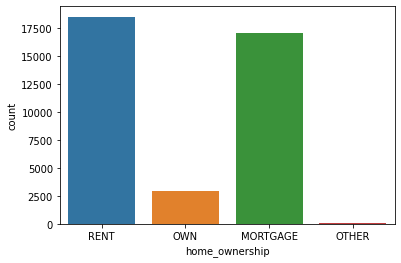

In [ ]:
sns.countplot(data=df, x='home_ownership')
plt.show()

#### Insights
- The most frequently occuring category in column **home_ownership** is **RENT**

#### Recommendation
- Missing values in column **home_ownership** can be replaced with it's mode i.e **RENT**

In [ ]:
df.loc[df.home_ownership.isnull(), 'home_ownership'] = 'RENT'

In [ ]:
df['home_ownership'].isnull().sum()

0

### Interpreting missing values in **emp_length** column

In [ ]:
df['emp_length'].value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [ ]:
## Generally, experience of an employee can be estimated based on their annual income.
df.groupby('emp_length')['annual_inc'].median()

emp_length
< 1 year     50000.0
1 year       51996.0
2 years      52000.0
3 years      55137.0
4 years      57998.0
5 years      57996.0
6 years      60000.0
7 years      60000.0
8 years      60000.0
9 years      65000.0
10+ years    69739.5
Name: annual_inc, dtype: float64

In [ ]:
## The above median values of each category doesnt differ much.
## Hence, lets try reducing the number of categories
reduced_catgs={'< 1 year':'<3 years', '1 year':'<3 years', '2 years':'<3 years',
               '3 years':'3-6 years', '4 years':'3-6 years', '5 years':'3-6 years',
               '6 years':'6-9 years', '7 years':'6-9 years', '8 years':'6-9 years',
               '9 years':'9+ years', '10+ years':'9+ years'}
df['emp_length'] = df['emp_length'].map(reduced_catgs)
df['emp_length'] = pd.Categorical(df['emp_length'], categories=('<3 years', '3-6 years',
                                                                '6-9 years','9+ years'),
                                  ordered=True)

In [ ]:
df.groupby('emp_length')['annual_inc'].median()

emp_length
<3 years     50700.0
3-6 years    57000.0
6-9 years    60000.0
9+ years     68400.0
Name: annual_inc, dtype: float64

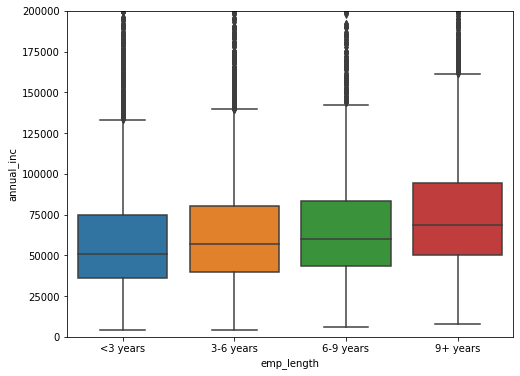

In [ ]:
# The below 
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df, x='emp_length', y='annual_inc', ax=ax)
ax.set_ylim(0, 200000)
plt.show()

In [ ]:
median_vals = df.groupby('emp_length')['annual_inc'].median()
median_vals

emp_length
<3 years     50700.0
3-6 years    57000.0
6-9 years    60000.0
9+ years     68400.0
Name: annual_inc, dtype: float64

#### Insights
- Now each category of `emp_length` column differ in distribution of their annual income.

#### Recommendation
- The missing values of `emp_length` column can be interpreted based on the employee's annual income 

In [ ]:
df.loc[df.emp_length.isnull() & ((df.annual_inc >= 0) & (df.annual_inc < 50700)), 'emp_length'] = '<3 years'
df.loc[df.emp_length.isnull() & ((df.annual_inc >= 50700) & (df.annual_inc < 57000)), 'emp_length'] = '3-6 years'
df.loc[df.emp_length.isnull() & ((df.annual_inc >= 57000) & (df.annual_inc < 60000)), 'emp_length'] = '6-9 years'
df.loc[df.emp_length.isnull() & (df.annual_inc >= 60000), 'emp_length'] = '9+ years'

In [ ]:
df.emp_length.isnull().sum()

0

### Interpreting missing values in **revol_util** column

In [ ]:
df['revol_util'].median()

49.1

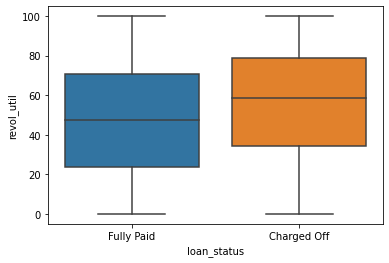

In [ ]:
sns.boxplot(data=df, y='revol_util', x='loan_status')
plt.show()

In [ ]:
df.groupby('loan_status')['revol_util'].median()

loan_status
Charged Off    58.4
Fully Paid     47.6
Name: revol_util, dtype: float64

#### Insights
- The overall median score of **revol_util** is 49.1 .
- Meanwhile the median scores of **revol_util**, between **Fully Paid** and **Charged Off** differ.


#### Recommendation
- The missing values of **revol_util** can be interpreted for each group, identified by loan status.

In [ ]:
median_vals = df.groupby('loan_status')['revol_util'].median()
df.loc[df.revol_util.isnull() & (df.loan_status == 'Fully Paid'), 'revol_util'] = median_vals.loc['Fully Paid']
df.loc[df.revol_util.isnull() & (df.loan_status == 'Charged Off'), 'revol_util'] = median_vals.loc['Charged Off']

In [ ]:
df.revol_util.isnull().sum()

0

### Interpreting *missing* values in **pub_rec_bankruptcies** column

In [ ]:
df.pub_rec_bankruptcies.value_counts()

0.0    36238
1.0     1637
2.0        5
Name: pub_rec_bankruptcies, dtype: int64

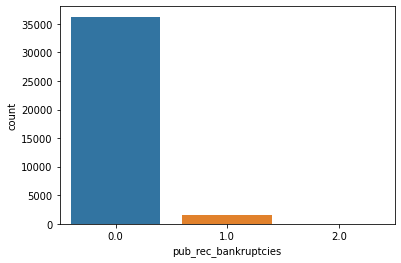

In [ ]:
sns.countplot(data=df, x='pub_rec_bankruptcies')
plt.show()

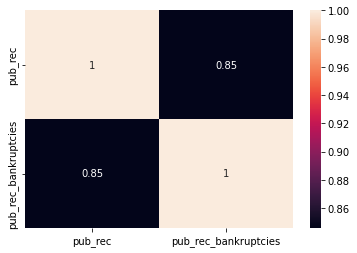

In [ ]:
sns.heatmap(df[['pub_rec', 'pub_rec_bankruptcies']].corr(), annot=True)
plt.show()

In [ ]:
df.groupby(by=['pub_rec'])['pub_rec_bankruptcies'].value_counts()

pub_rec  pub_rec_bankruptcies
0        0.0                     35830
1        1.0                      1637
         0.0                       357
2        0.0                        42
         2.0                         5
3        0.0                         7
4        0.0                         2
Name: pub_rec_bankruptcies, dtype: int64

#### Insights
- `pub_rec_bankruptcies` column has high corelation with `pub_rec` column.



#### Recommendation
- Based on the value of `pub_rec` column, we can interpret missing value in column `pub_rec_bankruptcies` as the mode of `pub_rec_bankruptcies` column observed for that particular `pub_rec` value.

In [ ]:
df.loc[df.pub_rec_bankruptcies.isnull() & (df.pub_rec==0), 'pub_rec_bankruptcies'] = 0
df.loc[df.pub_rec_bankruptcies.isnull() & (df.pub_rec==1), 'pub_rec_bankruptcies'] = 1
df.loc[df.pub_rec_bankruptcies.isnull() & (df.pub_rec==2), 'pub_rec_bankruptcies'] = 0
df.loc[df.pub_rec_bankruptcies.isnull() & (df.pub_rec==3), 'pub_rec_bankruptcies'] = 0
df.loc[df.pub_rec_bankruptcies.isnull() & (df.pub_rec==4), 'pub_rec_bankruptcies'] = 0

In [ ]:
df.pub_rec_bankruptcies.isnull().sum()

0

In [ ]:
# Checking any columns are left with missing values
df.columns[df.isnull().sum()>0]

Index([], dtype='object')

## Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 1077501 to 87023
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_amnt             38577 non-null  int64         
 1   term                  38577 non-null  int64         
 2   int_rate              38577 non-null  float64       
 3   grade                 38577 non-null  category      
 4   sub_grade             38577 non-null  category      
 5   emp_length            38577 non-null  category      
 6   home_ownership        38577 non-null  object        
 7   annual_inc            38577 non-null  float64       
 8   verification_status   38577 non-null  object        
 9   loan_status           38577 non-null  object        
 10  purpose               38577 non-null  object        
 11  addr_state            38577 non-null  object        
 12  dti                   38577 non-null  float64       
 13  delinq_2yrs    

In [ ]:
categorical_cols = ['grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status',
                    'purpose', 'addr_state', 'inq_last_6mths',
                    'delinq_2yrs', 'open_acc', 'pub_rec',
                    'total_acc', 'pub_rec_bankruptcies',
                    'sub_grade'
                    ]

### Analyzing the relation between grade and interest rate

- The **grade** of a borrower generally indicates worthiness of a borrower and is based on his/her past history of loans.
- Usually a borrower with high grade gets low interest rate offered and vice versa.

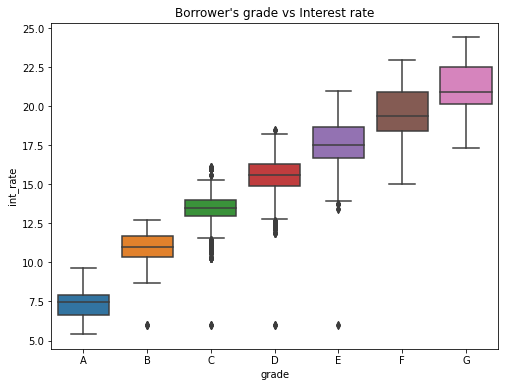

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df, x='grade', y='int_rate')
ax.set_title("Borrower's grade vs Interest rate")
plt.show()

#### Insights
- Clearly above figure shows that thers is a relationship between borrower's grade and the interest rate at which loan is borrowed.
- Borrowers with high grades like 'A', 'B' are likey to get loans at cheaper interest rates and vice versa

### Analyzing the relation between sub grade and interest rate

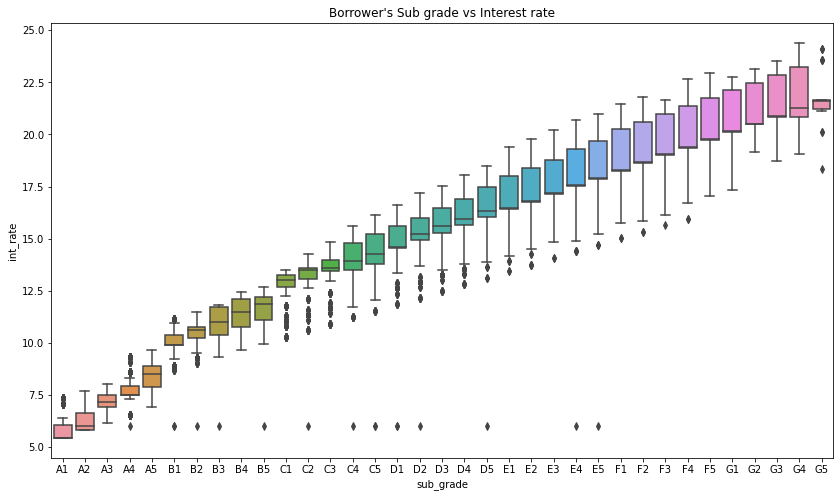

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=df, x='sub_grade', y='int_rate')
ax.set_title("Borrower's Sub grade vs Interest rate")
plt.show()

#### Insights
- Overall we can see the trend of increase in interest rate with decrease in borrower's sub grade.
- However, the differnce in distribution of interest rates across all consecutive sub grades is not subtle.

#### Recommendation
- Due to high granularity and lack of difference, in interest rates, across all sub grades we can drop **sub_grade** column.

In [ ]:
df = df.drop(columns=['sub_grade'])

### Analyzing the realtion between grade and loan status

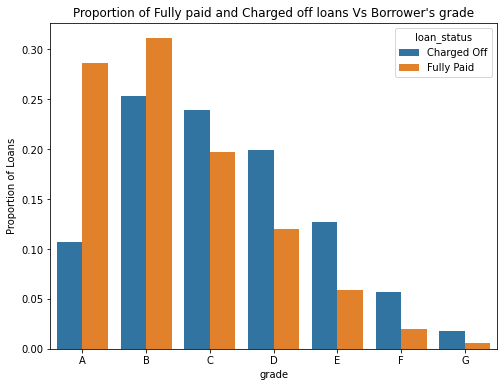

In [ ]:
plot_loan_proportions_across(df, 'grade', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's grade")

#### Insights
- The proportion of defaulted loans increased with decrease in the borrower's grade.
- Meanwhile, the proportion of fully paid loans decreased with decrease in the borrower's grade.

#### Recommendation
- Borrowers with grade 'A' are highly unlikey to default. Targeting these borrowers will reduce the risk.
- Borrowers with grade 'C' and above are more likely to default.

### Analyzing the realtion between employee tenure and loan status

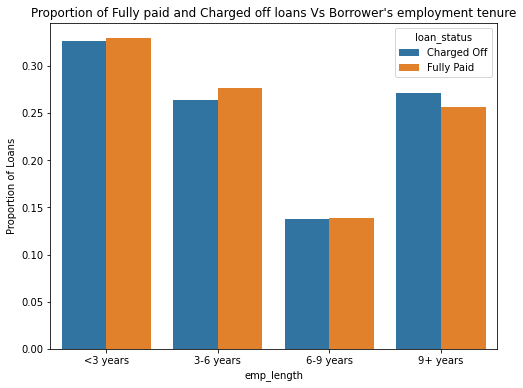

In [ ]:
plot_loan_proportions_across(df, 'emp_length', 'loan_status', 
                             plot_type='bar',
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's employment tenure")

#### Insights
- There is no significant difference in proportions of fully paid and charged off loans across different ranges of borrower's employment tenure.

### Analyzing the realtion between home ownership and loan status

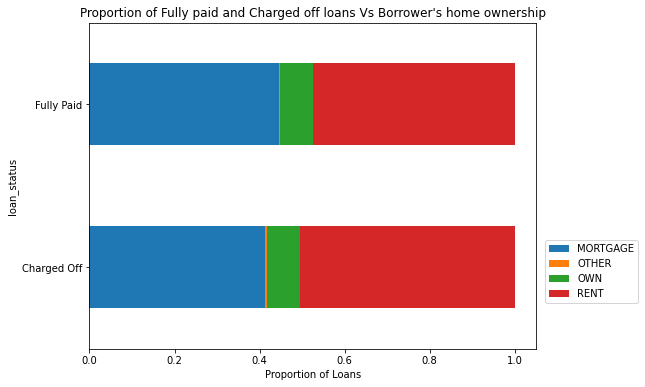

In [ ]:
plot_loan_proportions_across(df, 'home_ownership', 'loan_status', 
                             plot_type='stacked_bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's home ownership")

#### Insights
- Borrowers staying in rented homes are slightly more likely to default. 

### Analyzing the realtion between verification status and loan status

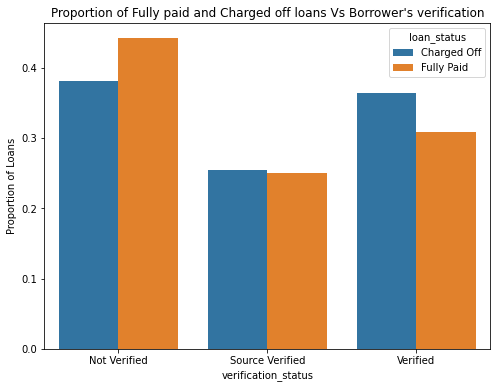

In [ ]:
plot_loan_proportions_across(df, 'verification_status', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's verification")

#### Insights
- Verifying the income source details of borrowers reduces the risk of default.

### Analyzing the realtion between borrower's state and loan status

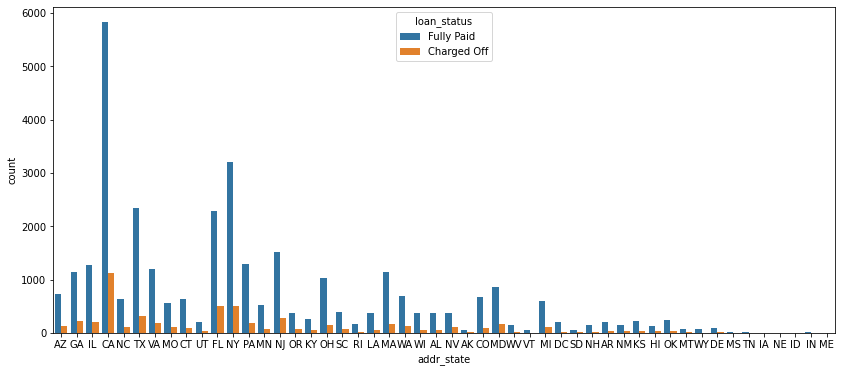

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(data=df, x='addr_state', hue='loan_status', ax=ax)
plt.show()

#### Insights
- More number of charged off loans are assocaited with high cost of living states like California, Texas, Florida, New york, and New Jersey 

### Analyzing the realtion between loan purpose and loan status

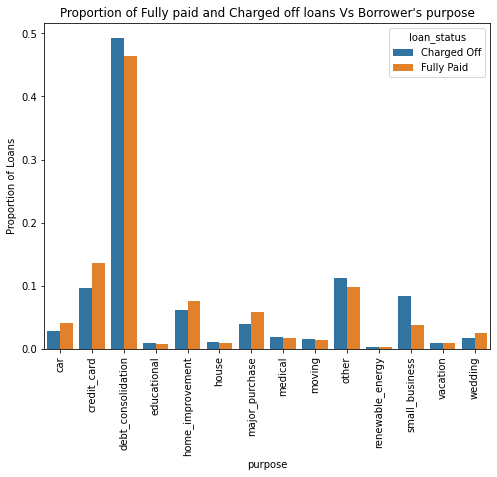

In [ ]:
plot_loan_proportions_across(df, 'purpose', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's purpose", 
                             rotate=True)

#### Insights
- Borrowers taking loans for purpose of `debt consolidation`, `small business` and `other` are more likely to default.
- On other hand, borrowers taking loans for purpose of `car`, `credit card`, `home improvement`, `major purchase` and `wedding` are more unlikely to default

### Analyzing the realtion between borrower's inqury and loan status

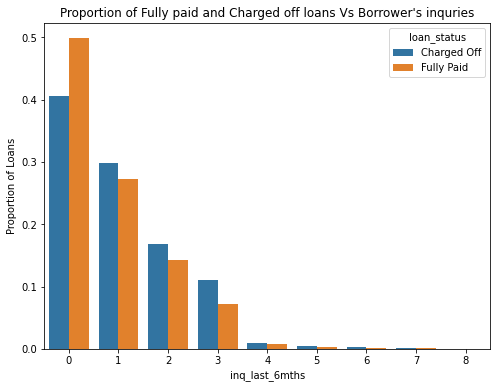

In [ ]:
plot_loan_proportions_across(df, 'inq_last_6mths', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's inquries")

In [ ]:
# Deriving a binary variable and dropping the 'inq_last_6mths' column 
df['is_inq_last_6mths'] = df['inq_last_6mths'].apply(lambda x: 1 if x > 0 else 0 )
df = df.drop(columns=['inq_last_6mths'])

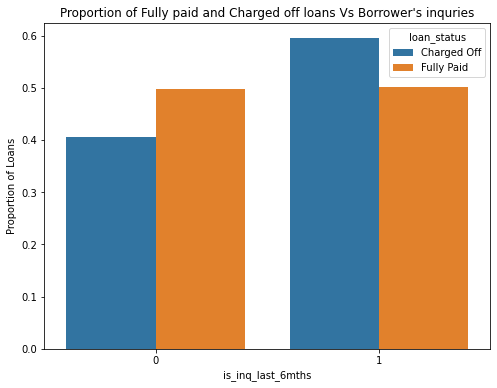

In [ ]:
plot_loan_proportions_across(df, 'is_inq_last_6mths', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's inquries")

#### Insights
- The borrower's who have done any inquiries in last 6 months, about their credit history, are more likely to default.

#### Recommendation
- Look for borrowers who have not done any inquiries in last six months for reducing the risk of default

### Analyzing the realtion between borrower's delinq and loan status

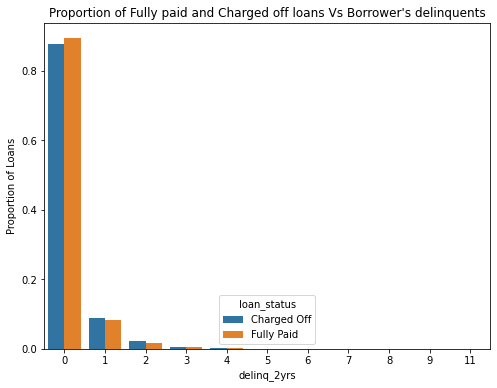

In [ ]:
plot_loan_proportions_across(df, 'delinq_2yrs', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's delinquents")

In [ ]:
# Deriving a binary variable and dropping the 'delinq_2yrs' column 
df['is_delinq_2yrs'] = df['delinq_2yrs'].apply(lambda x: 1 if x > 0 else 0 )
df = df.drop(columns=['delinq_2yrs'])

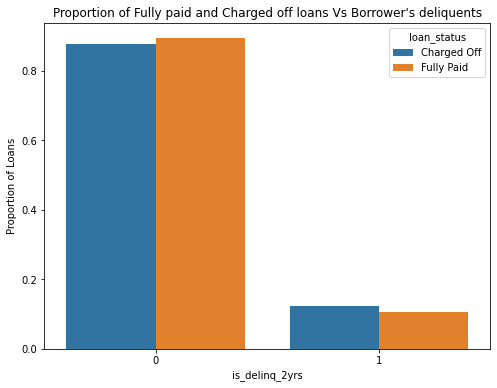

In [ ]:
plot_loan_proportions_across(df, 'is_delinq_2yrs', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's deliquents")

#### Insights
- The borrower's who were delinquent in last 2 years likely to default. However the difference from non deliquent users is not subtle

### Analyzing the realtion between borrower's open credit accounts and loan status

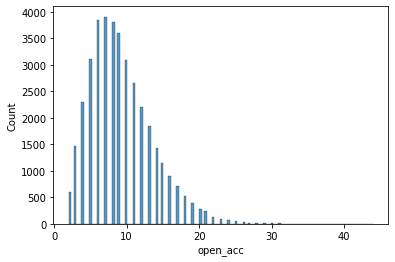

In [ ]:
sns.histplot(data=df, x='open_acc')
plt.show()

In [ ]:
# Bucketizing number of open accounts into
# Low, Medium and High buckets
df['open_acc'] = pd.cut(df.open_acc, bins=[0, 10, 20, 50], labels=['Low', 'Medium', 'High'])
df['open_acc'].value_counts()

Low       25750
Medium    12097
High        730
Name: open_acc, dtype: int64

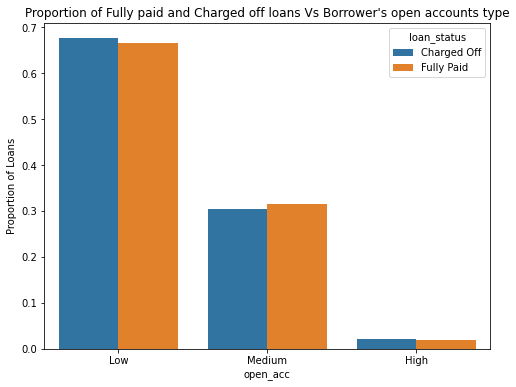

In [ ]:
plot_loan_proportions_across(df, 'open_acc', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's open accounts type")

#### Insights
- The proportion of charged off and fully paid loans across three different ranges of open accounts is almost same

### Analyzing the realtion between borrower's total records and loan status

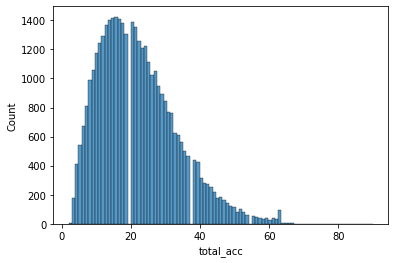

In [ ]:
sns.histplot(data=df, x='total_acc')
plt.show()

In [ ]:
df['total_acc'] = pd.cut(df.total_acc, bins=[0, 20, 40, 100], 
                         labels=['Low', 'Medium', 'High'])
df['total_acc'].value_counts()

Low       19471
Medium    16391
High       2715
Name: total_acc, dtype: int64

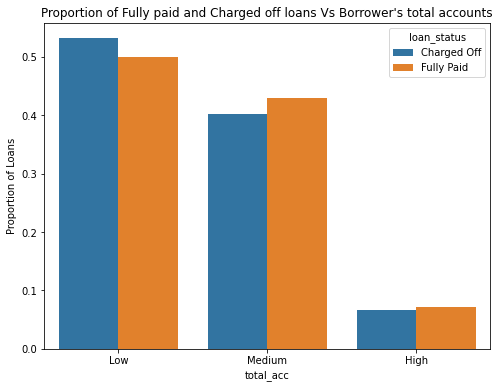

In [ ]:
plot_loan_proportions_across(df, 'total_acc', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's total accounts")

#### Insights
- 

### Analyzing the realtion between borrower's public records and loan status

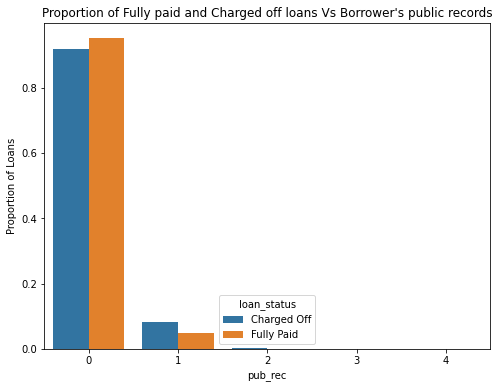

In [ ]:
plot_loan_proportions_across(df, 'pub_rec', 'loan_status',
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's public records")

In [ ]:
# Deriving a binary variable and dropping the 'pub_rec' column
df['is_pub_rec'] = df['pub_rec'].apply(lambda x: 1 if x > 0 else 0 )
df = df.drop(columns=['pub_rec'])

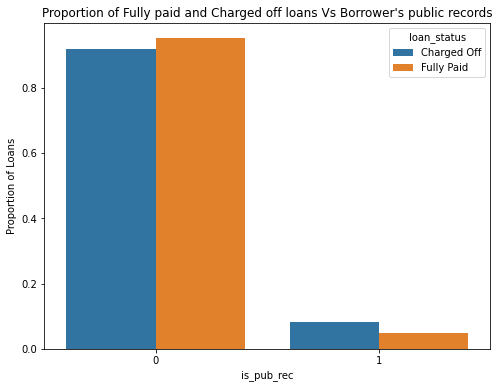

In [ ]:
plot_loan_proportions_across(df, 'is_pub_rec', 'loan_status', 
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's public records")

### Analyzing the realtion between borrower's public bankruptcies and loan status

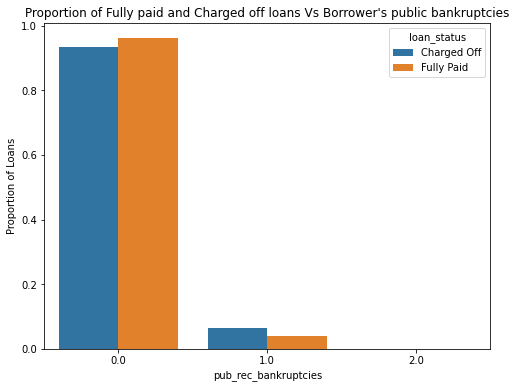

In [ ]:
plot_loan_proportions_across(df, 'pub_rec_bankruptcies', 'loan_status',
                             plot_type='bar', 
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's public bankruptcies")

In [ ]:
# Deriving a binary variable and dropping the 'pub_rec_bankruptcies' column
df['is_pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0 else 0 )
df = df.drop(columns=['pub_rec_bankruptcies'])

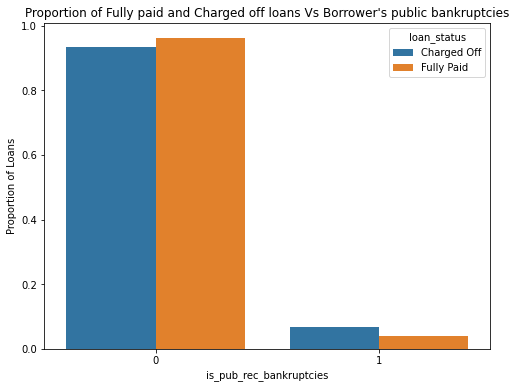

In [ ]:
plot_loan_proportions_across(df, 'is_pub_rec_bankruptcies', 'loan_status',
                             plot_type='bar', title="Proportion of Fully paid and Charged off loans Vs Borrower's public bankruptcies")

### Analyzing relation between loan amount and loan status

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 1077501 to 87023
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   loan_amnt                38577 non-null  int64         
 1   term                     38577 non-null  int64         
 2   int_rate                 38577 non-null  float64       
 3   grade                    38577 non-null  category      
 4   emp_length               38577 non-null  category      
 5   home_ownership           38577 non-null  object        
 6   annual_inc               38577 non-null  float64       
 7   verification_status      38577 non-null  object        
 8   loan_status              38577 non-null  object        
 9   purpose                  38577 non-null  object        
 10  addr_state               38577 non-null  object        
 11  dti                      38577 non-null  float64       
 12  earliest_cr_line         38577 

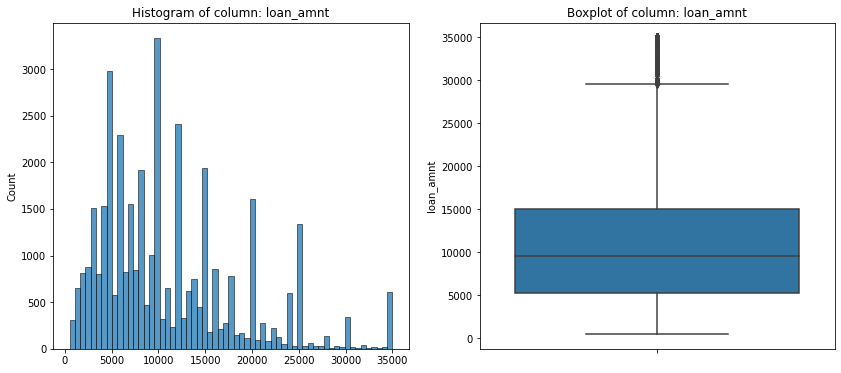

In [ ]:
# Viewing histogram and boxplot of 'loan_amnt' variable
plot_numerical_distribution(df, 'loan_amnt')

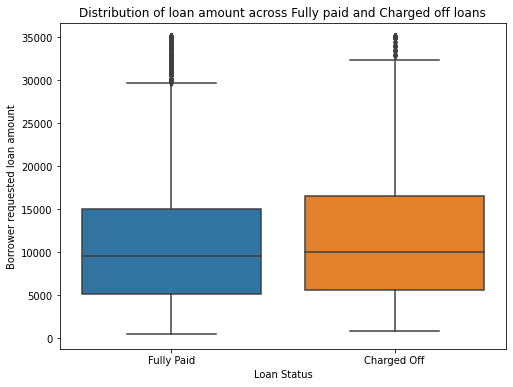

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df, x='loan_status', y='loan_amnt', ax=ax)
ax.set_title('Distribution of loan amount across Fully paid and Charged off loans')
ax.set_xlabel('Loan Status')
ax.set_ylabel("Borrower requested loan amount")
plt.show()

### Analyzing relation between annual income and loan status

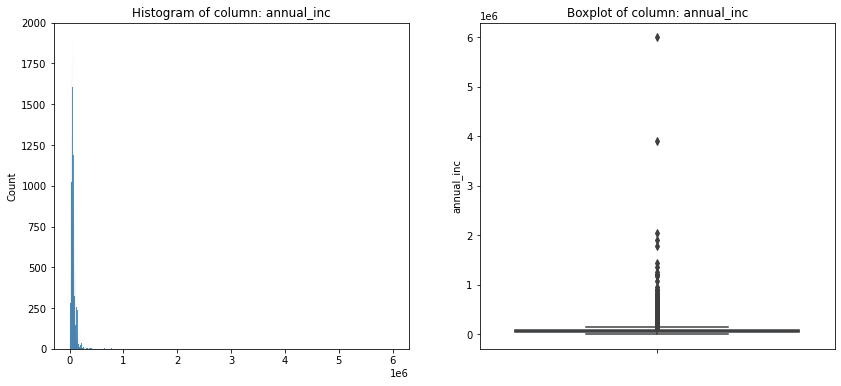

In [ ]:
plot_numerical_distribution(df, 'annual_inc')

#### Insights
- Annual income of borrowers is highly skewed towards lower income values.

#### Recommendation
- Bin annual incomes of borrowers into various income groups and further analyze the distribution of loans within each income group.

In [ ]:
df.annual_inc.describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [ ]:
df['income_group'] = pd.cut(df.annual_inc, bins=[0, 25000, 50000, 75000, 100000, 700000],
                            labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

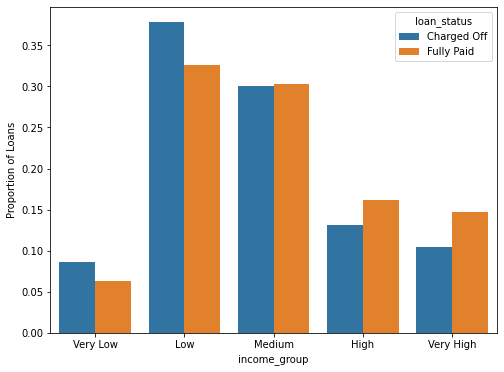

In [ ]:
plot_loan_proportions_across(df, 'income_group', 'loan_status',
                             plot_type='bar',
                             title="")

#### Insights
- Borrowers belonging to **Very Low** and **Low** income groups (annual_inc <= 50000) are more likely to get default.
- On other hand, borrowers of **High** and **Very High** income groups (annual_inc > 75000) are less likely to default.

#### Recommendations
- 

### Analyzing relation between debt to income and loan status

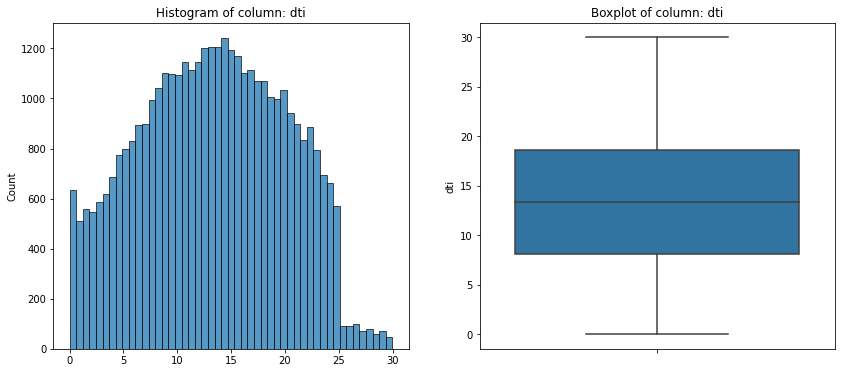

In [ ]:
plot_numerical_distribution(df, 'dti')

In [ ]:
df['dti'].describe()

count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.130000
50%         13.370000
75%         18.560000
max         29.990000
Name: dti, dtype: float64

In [ ]:
df['dti_group'] = pd.cut(df.dti, bins=[0, 10, 20, 30],
                         labels=['Low', 'Medium', 'High'])

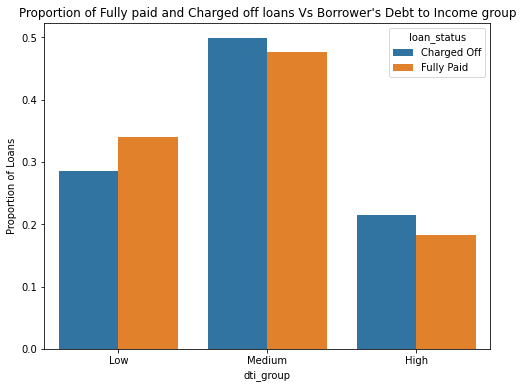

In [ ]:
plot_loan_proportions_across(df, 'dti_group', 'loan_status',
                             plot_type='bar',
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's Debt to Income group")

#### Insights
- Borrowers having **Low** debt to income group (dti <= 10) are less likely to get default.
- On other hand, borrowers having **High** debt to income group (dti > 20) are more likely to default.

#### Recommendation


### Analyzing relation between revolving balance and loan status

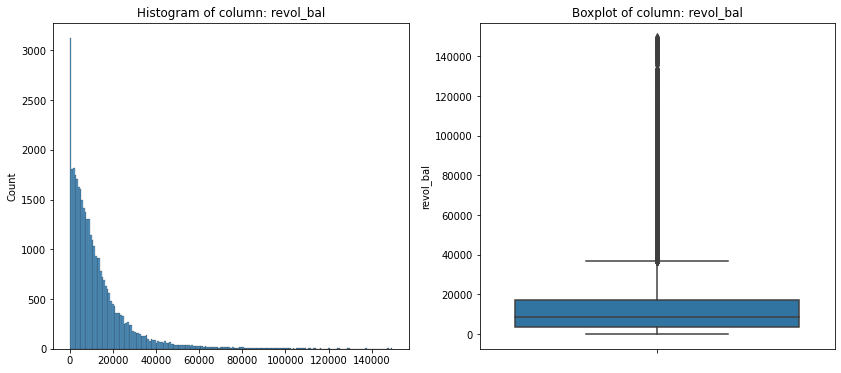

In [ ]:
plot_numerical_distribution(df, 'revol_bal')

#### Insights
- Borrowers  revolving balance is also highly skewed towards lower income values.

#### Recommendation
- Bin revolving balance of borrowers into various groups and further analyze the distribution of loans within each group.

In [ ]:
df.revol_bal.describe().T

count     38577.000000
mean      13289.489826
std       15866.492241
min           0.000000
25%        3650.000000
50%        8762.000000
75%       16912.000000
max      149588.000000
Name: revol_bal, dtype: float64

In [ ]:
df['revol_group'] = pd.cut(df.revol_bal, bins=[0, 5000, 15000, 150000],
                           labels=['Low', 'Medium', 'High'])

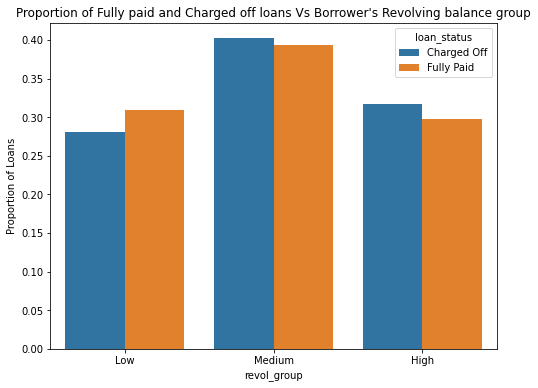

In [ ]:
plot_loan_proportions_across(df, 'revol_group', 'loan_status',
                             plot_type='bar',
                             title="Proportion of Fully paid and Charged off loans Vs Borrower's Revolving balance group")

#### Insights
- Borrowers having **Low** revolving balance (revol_bal <= 5000) are less likely to get default.
- On other hand, borrowers having **High** revolving balance (revol_bal > 15000) are more likely to default.

### Analyzing relation between revolving utilization and loan status

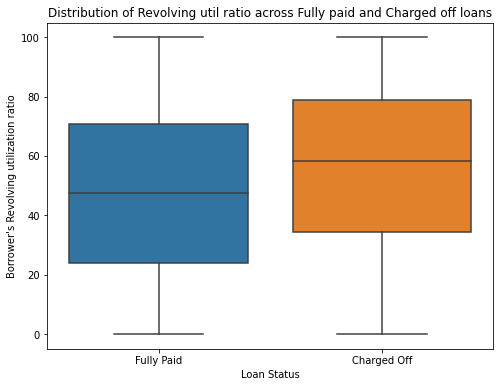

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df, x='loan_status', y='revol_util', ax=ax)
ax.set_title('Distribution of Revolving util ratio across Fully paid and Charged off loans')
ax.set_xlabel('Loan Status')
ax.set_ylabel("Borrower's Revolving utilization ratio")
plt.show()

#### Insights
- There is a significant difference in distributions of borrower's revolving utilization ratio.
- A higher revolving ratio (> 60%) indicates higher risk of default.
- A lower revolving ratio (< 40%) reduces risk of default.

#### Recommendations
- Target borrowers with lower revolving ratio for reducing risk of deault

### Analyzing coorelation across various numerical columns

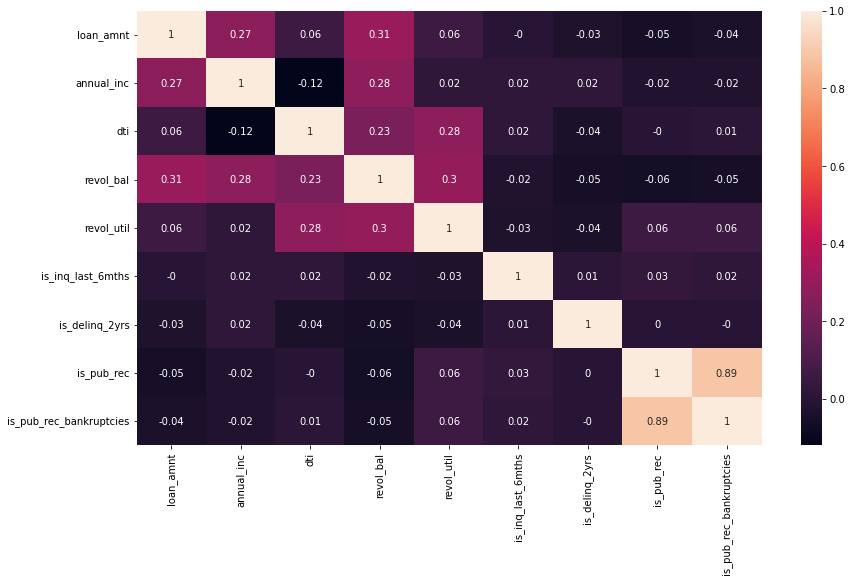

In [ ]:
numeric_cols =['loan_amnt', 'annual_inc', 'dti', 'revol_bal',
               'revol_util', 'is_inq_last_6mths', 'is_delinq_2yrs',
               'is_pub_rec', 'is_pub_rec_bankruptcies']
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(df[numeric_cols].corr().round(2), annot=True, ax=ax)
plt.show()

#### Insights
- The variables representing number of public records and number of public bankruptcies of a borrower are highly correlated (correlation = 0.89).

#### Recommendation
- Due to presence of high correlation we can either drop one of the variables or dervie a ratio of these two variables.

In [ ]:
df = df.drop(columns=['is_pub_rec_bankruptcies'])

## Final Recommendations

### Strong indicators
- Grade
- Revolving utilization ratio
- is_inq_last_6mths
- Debt to income group
- Annual income group

### Weak indicators
- home ownership
- verification status
- loan purpose
- borrower's address state
- Revolving balance
- is_delinq_2yrs
- is_pub_rec
